# American Airlines Random Forest Regression Model

## Import Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
features = pd.read_csv('all_tight_turns_seconds.csv')

C:\Users\mckee\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Establish a Baseline

If one expects that a plane in a tight turn situation will be turned over in a time less than or equal to MOGT, they will be correct 48.1% of the time.  Our accuracy rate needs to be significantly better than this in order to provide utility to the customer.

In [3]:
print('Baseline: {:.2%}'.format(features.Under_MOGT.sum() / len(features.Under_MOGT)))

Baseline: 48.11%


## Outlier Detection

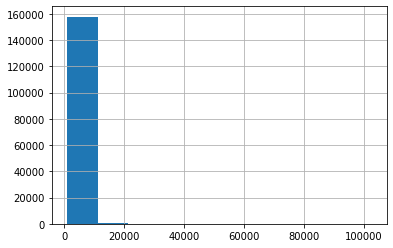

In [4]:
# Histogram
hist = features['TURN_TIME'].hist()

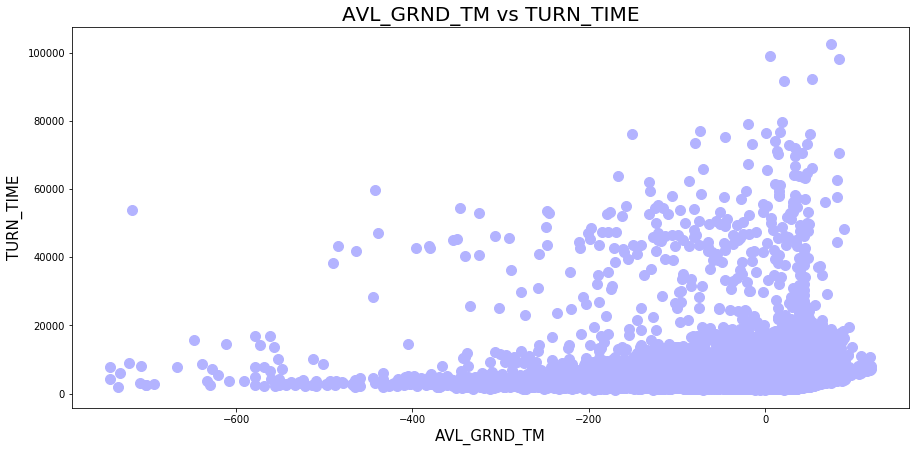

In [5]:
# Scatter plot of available ground time vs turn time
plt.figure(figsize=(15,7))
plt.scatter(features['AVL_GRND_TM'],features['TURN_TIME'],s=100,marker='o',color='#b3b3ff')
plt.title('AVL_GRND_TM vs TURN_TIME',fontsize=20)  
plt.xlabel('AVL_GRND_TM',fontsize=15)  
plt.ylabel('TURN_TIME',fontsize=15)  
plt.show()

## Remove Outliers 
Outliers with a turn time greater than 8 hours will be analyzed separately. 

In [6]:
features.shape

(159134, 48)

In [7]:
features.drop(features[features.TURN_TIME > 28800].index, inplace=True)
features.drop(features[features.AVL_GRND_TM < -200].index, inplace=True)

In [8]:
features.shape

(158060, 48)

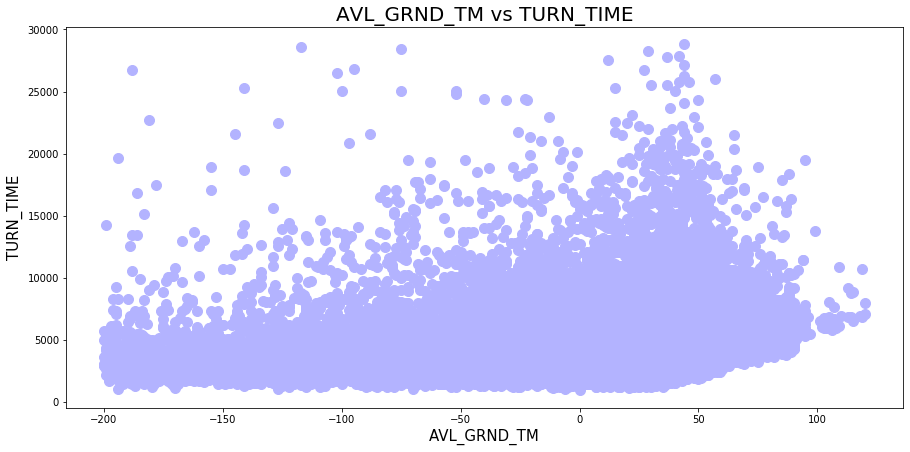

In [9]:
# Scatter plot of available ground time vs turn time
plt.figure(figsize=(15,7))
plt.scatter(features['AVL_GRND_TM'],features['TURN_TIME'],s=100,marker='o',color='#b3b3ff')
plt.title('AVL_GRND_TM vs TURN_TIME',fontsize=20)  
plt.xlabel('AVL_GRND_TM',fontsize=15)  
plt.ylabel('TURN_TIME',fontsize=15)  
plt.show()

## Pre-process the Data

In [10]:
features.head()

,AIRLINE,FLEET_CD,SUB_FLEET,ACTL_AIRCFT_TAIL_CD,INB_FLIGHT,INB_ACT_ORIG,INB_ACT_DTTM,SEATS,INB_PAX,OUTB_PAX,...,LAST_PAX_ON,TURN_TIME,Unloading_Time,First_Load_Action,Last_Action,Load_Time,Total_Time_From_First_Load_Action,Total_Boarding,Total_Bag_Loading_Time,Under_MOGT
0,AA,319,A319,1,62,IAH,1503587040,128,125,57,...,1503588480,2520,1216,1503587520,1503589184,1664,2040,960,476,True
1,AA,319,A319,1,120,MIA,1524318120,128,93,110,...,1524320280,2580,943,1524318240,1524320335,2095,2460,2040,1137,True
2,AA,319,A319,1,149,EGE,1545669180,128,113,97,...,1545670800,2340,969,1545669840,1545670800,960,1680,960,227,True
3,AA,319,A319,1,165,DFW,1528729140,128,89,85,...,1528730640,1800,601,1528729860,1528730718,858,1080,780,718,True
4,AA,319,A319,1,189,EGE,1504093140,128,76,88,...,1504095180,2820,887,1504093560,1504095281,1721,2400,1620,1089,False


#### Creating new columns

The following new columns are created below:
* inb_pct_full - the percentage of seats occupied on the inbound flight
* outb_pct_full - the percentage of seats occupied on the outbound flight
* sched_month - the month the flight was scheduled to leave
* sched_hour - the hour the flight was scheduled to leave
* arrival_hour - the hour the inbound flight arrived

In [11]:
features['inb_pct_full'] = features['INB_PAX'] / features['SEATS']
features['outb_pct_full'] = features['OUTB_PAX'] / features['SEATS']
features['sched_month'] = pd.to_datetime(features['SKD_DTTM']).dt.month
features['sched_day_of_week'] = pd.to_datetime(features['SKD_DTTM']).dt.dayofweek
features['sched_hour'] = pd.to_datetime(features['SKD_DTTM']).dt.hour
features['arrival_hour'] = pd.to_datetime(features['INB_ACT_DTTM']).dt.hour

#### Dummy variables

Here we convert categorical columns into one-hot encoded features

In [12]:
# Add dummy variables
features['AIRLINE_AA'] = np.where((features.AIRLINE == 'AA'),1,0)
features['A319_FLEET'] = np.where((features.FLEET_CD == 319),1,0)
features['A320_FLEET'] = np.where((features.FLEET_CD == 320),1,0)
features['A321_FLEET'] = np.where((features.FLEET_CD == 321),1,0)
features['A737_FLEET'] = np.where((features.FLEET_CD == 737),1,0)
features['A737_FLEET'] = np.where((features.FLEET_CD == '737'),1,0)
features['A757_FLEET'] = np.where((features.FLEET_CD == '757'),1,0)
features['E90_FLEET'] = np.where((features.FLEET_CD == 'E90'),1,0)
features['MIA_INB_FLIGHT'] = np.where((features.INB_FLIGHT == 'MIA'),1,0)
features['DFW_INB_FLIGHT'] = np.where((features.INB_FLIGHT == 'DFW'),1,0)
features['DCA_INB_FLIGHT'] = np.where((features.INB_FLIGHT == 'DCA'),1,0)
features['LAX_INB_FLIGHT'] = np.where((features.INB_FLIGHT == 'LAX'),1,0)
features['ORD_INB_FLIGHT'] = np.where((features.INB_FLIGHT == 'ORD'),1,0)
features['LGA_INB_FLIGHT'] = np.where((features.INB_FLIGHT == 'LGA'),1,0)
features['BOS_INB_FLIGHT'] = np.where((features.INB_FLIGHT == 'BOS'),1,0)
features['SFO_INB_FLIGHT'] = np.where((features.INB_FLIGHT == 'SFO'),1,0)
features['MIA_INB_ACT_ORIG'] = np.where((features.INB_ACT_ORIG == 'MIA'),1,0)
features['DFW_INB_ACT_ORIG'] = np.where((features.INB_ACT_ORIG == 'DFW'),1,0)
features['DCA_INB_ACT_ORIG'] = np.where((features.INB_ACT_ORIG == 'DCA'),1,0)
features['LAX_INB_ACT_ORIG'] = np.where((features.INB_ACT_ORIG == 'LAX'),1,0)
features['ORD_INB_ACT_ORIG'] = np.where((features.INB_ACT_ORIG == 'ORD'),1,0)
features['LGA_INB_ACT_ORIG'] = np.where((features.INB_ACT_ORIG == 'LGA'),1,0)
features['BOS_INB_ACT_ORIG'] = np.where((features.INB_ACT_ORIG == 'BOS'),1,0)
features['SFO_INB_ACT_ORIG'] = np.where((features.INB_ACT_ORIG == 'SFO'),1,0)
features['MIA_SCHD_LEG_DEP_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_DEP_AIRPRT_IATA_CD == 'MIA'),1,0)
features['DFW_SCHD_LEG_DEP_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_DEP_AIRPRT_IATA_CD == 'DFW'),1,0)
features['DCA_SCHD_LEG_DEP_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_DEP_AIRPRT_IATA_CD == 'DCA'),1,0)
features['LAX_SCHD_LEG_DEP_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_DEP_AIRPRT_IATA_CD == 'LAX'),1,0)
features['ORD_SCHD_LEG_DEP_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_DEP_AIRPRT_IATA_CD == 'ORD'),1,0)
features['LGA_SCHD_LEG_DEP_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_DEP_AIRPRT_IATA_CD == 'LGA'),1,0)
features['BOS_SCHD_LEG_DEP_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_DEP_AIRPRT_IATA_CD == 'BOS'),1,0)
features['SFO_SCHD_LEG_DEP_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_DEP_AIRPRT_IATA_CD == 'SFO'),1,0)
features['MIA_SCHD_LEG_ARVL_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_ARVL_AIRPRT_IATA_CD == 'MIA'),1,0)
features['DFW_SCHD_LEG_ARVL_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_ARVL_AIRPRT_IATA_CD == 'DFW'),1,0)
features['DCA_SCHD_LEG_ARVL_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_ARVL_AIRPRT_IATA_CD == 'DCA'),1,0)
features['LAX_SCHD_LEG_ARVL_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_ARVL_AIRPRT_IATA_CD == 'LAX'),1,0)
features['ORD_SCHD_LEG_ARVL_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_ARVL_AIRPRT_IATA_CD == 'ORD'),1,0)
features['LGA_SCHD_LEG_ARVL_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_ARVL_AIRPRT_IATA_CD == 'LGA'),1,0)
features['BOS_SCHD_LEG_ARVL_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_ARVL_AIRPRT_IATA_CD == 'BOS'),1,0)
features['SFO_SCHD_LEG_ARVL_AIRPRT_IATA_CD'] = np.where((features.SCHD_LEG_ARVL_AIRPRT_IATA_CD == 'SFO'),1,0)
features['DELAY_FLIGHT_CREW'] = np.where((features.PRIMARY_DELAY_REASON == 'FLIGHT CREW'),1,0)
features['DELAY_MAINTENANCE'] = np.where((features.PRIMARY_DELAY_REASON == 'MAINTENANCE'),1,0)
features['DELAY_WEATHER'] = np.where((features.PRIMARY_DELAY_REASON == 'WEATHER'),1,0)
features['DELAY_PILOT'] = np.where((features.PRIMARY_DELAY_REASON == 'PILOT'),1,0)

C:\Users\mckee\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


#### Selecting features

Here we select the features that we will use as inputs to our model.

In [13]:
# Print the features columns for easy review

features.columns

Index(['AIRLINE', 'FLEET_CD', 'SUB_FLEET', 'ACTL_AIRCFT_TAIL_CD', 'INB_FLIGHT',
       'INB_ACT_ORIG', 'INB_ACT_DTTM', 'SEATS', 'INB_PAX', 'OUTB_PAX', 'MOGT',
       'AVL_GRND_TM', 'TIGHT_TURN', 'OPERAT_FLIGHT_NBR', 'SCHD_LEG_DEP_LCL_DT',
       'STATION_TYPE', 'RQRD_BOARD_MIN', 'SCHD_LEG_DEP_AIRPRT_IATA_CD',
       'SCHD_LEG_ARVL_AIRPRT_IATA_CD', 'SKD_DTTM', 'ACT_DTTM', 'DELAY_MIN',
       'PRIMARY_DELAY_REASON', 'FIRST_BAG_OFF', 'FIRST_QRTL_BAG_OFF',
       'MEDIAN_BAG_OFF', 'THIRD_QRTL_BAG_OFF', 'LAST_BAG_OFF', 'FIRST_BAG_ON',
       'FIRST_QRTL_BAG_ON', 'MEDIAN_BAG_ON', 'THIRD_QRTL_BAG_ON',
       'LAST_BAG_ON', 'FA_MIN_CREW', 'FIRST_PAX_ON', 'FIRST_QRTL_PAX_ON',
       'MEDIAN_PAX_ON', 'THIRD_QRTL_PAX_ON', 'LAST_PAX_ON', 'TURN_TIME',
       'Unloading_Time', 'First_Load_Action', 'Last_Action', 'Load_Time',
       'Total_Time_From_First_Load_Action', 'Total_Boarding',
       'Total_Bag_Loading_Time', 'Under_MOGT', 'inb_pct_full', 'outb_pct_full',
       'sched_month', 'sched_day_of

In [14]:
# Narrow the features list to the relevant features

features = features[['INB_PAX'
                    , 'OUTB_PAX'
                    , 'MOGT'
                    , 'AVL_GRND_TM'
                    , 'RQRD_BOARD_MIN'
                    , 'SCHD_LEG_DEP_AIRPRT_IATA_CD'
                    , 'SCHD_LEG_ARVL_AIRPRT_IATA_CD'
                    , 'FIRST_BAG_OFF'
                    , 'LAST_BAG_OFF'
                    , 'FIRST_BAG_ON'
                    , 'LAST_BAG_ON'
                    , 'FA_MIN_CREW'
                    , 'FIRST_PAX_ON'
                    , 'LAST_PAX_ON'
                    , 'TURN_TIME'
                    , 'inb_pct_full'
                    , 'outb_pct_full'
                    , 'sched_month'
                    , 'sched_day_of_week'
                    , 'sched_hour'
                    , 'arrival_hour'
                    , 'AIRLINE_AA'
                    , 'A319_FLEET'
                    , 'A320_FLEET'
                    , 'A321_FLEET'
                    , 'A737_FLEET'
                    , 'A757_FLEET'
                    , 'E90_FLEET'
                    , 'MIA_INB_FLIGHT'
                    , 'DFW_INB_FLIGHT'
                    , 'DCA_INB_FLIGHT'
                    , 'LAX_INB_FLIGHT'
                    , 'ORD_INB_FLIGHT'
                    , 'LGA_INB_FLIGHT'
                    , 'BOS_INB_FLIGHT'
                    , 'SFO_INB_FLIGHT'
                    , 'MIA_INB_ACT_ORIG'
                    , 'DFW_INB_ACT_ORIG'
                    , 'DCA_INB_ACT_ORIG'
                    , 'LAX_INB_ACT_ORIG'
                    , 'ORD_INB_ACT_ORIG'
                    , 'LGA_INB_ACT_ORIG'
                    , 'BOS_INB_ACT_ORIG'
                    , 'SFO_INB_ACT_ORIG'
                    , 'MIA_SCHD_LEG_DEP_AIRPRT_IATA_CD'
                    , 'DFW_SCHD_LEG_DEP_AIRPRT_IATA_CD'
                    , 'DCA_SCHD_LEG_DEP_AIRPRT_IATA_CD'
                    , 'LAX_SCHD_LEG_DEP_AIRPRT_IATA_CD'
                    , 'ORD_SCHD_LEG_DEP_AIRPRT_IATA_CD'
                    , 'LGA_SCHD_LEG_DEP_AIRPRT_IATA_CD'
                    , 'BOS_SCHD_LEG_DEP_AIRPRT_IATA_CD'
                    , 'SFO_SCHD_LEG_DEP_AIRPRT_IATA_CD'
                    , 'MIA_SCHD_LEG_ARVL_AIRPRT_IATA_CD'
                    , 'DFW_SCHD_LEG_ARVL_AIRPRT_IATA_CD'
                    , 'DCA_SCHD_LEG_ARVL_AIRPRT_IATA_CD'
                    , 'LAX_SCHD_LEG_ARVL_AIRPRT_IATA_CD'
                    , 'ORD_SCHD_LEG_ARVL_AIRPRT_IATA_CD'
                    , 'LGA_SCHD_LEG_ARVL_AIRPRT_IATA_CD'
                    , 'BOS_SCHD_LEG_ARVL_AIRPRT_IATA_CD'
                    , 'SFO_SCHD_LEG_ARVL_AIRPRT_IATA_CD'
                    , 'DELAY_FLIGHT_CREW'
                    , 'DELAY_MAINTENANCE'
                    , 'DELAY_WEATHER'
                    , 'DELAY_PILOT']]

features.head()

,INB_PAX,OUTB_PAX,MOGT,AVL_GRND_TM,RQRD_BOARD_MIN,SCHD_LEG_DEP_AIRPRT_IATA_CD,SCHD_LEG_ARVL_AIRPRT_IATA_CD,FIRST_BAG_OFF,LAST_BAG_OFF,FIRST_BAG_ON,...,DCA_SCHD_LEG_ARVL_AIRPRT_IATA_CD,LAX_SCHD_LEG_ARVL_AIRPRT_IATA_CD,ORD_SCHD_LEG_ARVL_AIRPRT_IATA_CD,LGA_SCHD_LEG_ARVL_AIRPRT_IATA_CD,BOS_SCHD_LEG_ARVL_AIRPRT_IATA_CD,SFO_SCHD_LEG_ARVL_AIRPRT_IATA_CD,DELAY_FLIGHT_CREW,DELAY_MAINTENANCE,DELAY_WEATHER,DELAY_PILOT
0,125,57,45,25,30,MIA,STL,1503587278,1503588256,1503588708,...,0,0,0,0,0,0,0,0,0,0
1,93,110,50,48,45,SAP,MIA,1524318590,1524319063,1524319198,...,0,0,0,0,0,0,0,0,0,0
2,113,97,45,27,30,LAX,SFO,1545669578,1545670149,1545670311,...,0,0,0,0,0,1,0,0,0,0
3,89,85,40,-38,30,EGE,DFW,1528729429,1528729741,1528730000,...,0,0,0,0,0,0,0,0,0,0
4,76,88,45,41,30,DFW,MKE,1504093362,1504094027,1504094192,...,0,0,0,0,0,0,0,0,0,0


#### Dummy variables

Here we convert categorical columns into one-hot encoded features

In [15]:
features = pd.get_dummies(features)
features.columns
imp_features = features

#### Drop features

Based on results from previous model runs, we drop the columns below.  These features have very little impact on the model results, so they are dropped to allow for faster processing.

In [16]:
# # This would be better as a single function with a large list of features, but Jupyter was having trouble with large lists.

# features = features.drop(['PRIMARY_DELAY_REASON_ATC'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_CATERING'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_CONNECTIONS'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_DAMAGE'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_FLIGHT ATTENDANT'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_FUELING'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_IT'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_LATE ARRIVING EQUIPMENT'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_LOAD PLANNING'], axis=1)
# features = features.drop([r'PRIMARY_DELAY_REASON_LOADING BAGGAGE/CARGO'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_MISCELLANEOUS'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_OPERATIONAL CODES'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_PASSENGER SERVICE'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_SECURITY'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_SERVICING'], axis=1)
# features = features.drop(['PRIMARY_DELAY_REASON_UNKNOWN'], axis=1)

# features.columns

#### Extract features and labels

Here we create an array of features and an array of labels. The features will be the input to our model and the labels will be the outcome we are measuring (TURN_TIME).

In [17]:
labels = np.array(features['TURN_TIME'])

features = features.drop(['TURN_TIME'], axis=1)

feature_list = list(features.columns)

features = np.array(features)


#### Split the data into training and testing sets

In [18]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.25)

In [19]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (118545, 440)
Training Labels Shape: (118545,)
Testing Features Shape: (39515, 440)
Testing Labels Shape: (39515,)


## Train Model

We train the model with Scikit-Learn's RandomForestRegressor.

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, max_depth=70, min_samples_leaf=50, max_features='auto')

rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=50, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## Make Predictions on the Test Set

Predict the turn time for each flight in the test set and record the average error in seconds and percentage.

In [21]:
from sklearn.metrics import mean_absolute_error

predictions = rf.predict(test_features)

# Calculate the Mean Absolute Error
mae = round(mean_absolute_error(test_labels, predictions)/60,2)
print('Mean Absolute Error:', mae, 'minutes.')

# Calculate the Mean Absolute Percent Error
errors = abs(predictions - test_labels)
mape = 100 * (errors / test_labels)

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%')

Mean Absolute Error: 10.06 minutes.
Accuracy: 84.58 %


## Final Results

Here we create a DataFrame of the testing set, complete with our prediction, the real-world outcome, and a column comparing the two.

In [24]:
# Create a DataFrame using the testing set
testdf = pd.DataFrame(test_features, columns=feature_list)

# Add the prediction and actual outcome columns
testdf['prediction'] = predictions
testdf['actual'] = test_labels

# Add the prediction and actual under_MOGT columns
testdf['actual_under_MOGT'] = testdf['actual'] <= (testdf['MOGT'] * 60)
testdf['pred_under_MOGT'] = testdf['prediction'] <= (testdf['MOGT'] * 60)

# Add a column to show if our prediction was correct
testdf['correct'] = testdf['actual_under_MOGT'] == testdf['pred_under_MOGT']


testdf.head()

,INB_PAX,OUTB_PAX,MOGT,AVL_GRND_TM,RQRD_BOARD_MIN,FIRST_BAG_OFF,LAST_BAG_OFF,FIRST_BAG_ON,LAST_BAG_ON,FA_MIN_CREW,...,SCHD_LEG_ARVL_AIRPRT_IATA_CD_YUL,SCHD_LEG_ARVL_AIRPRT_IATA_CD_YVR,SCHD_LEG_ARVL_AIRPRT_IATA_CD_YYZ,SCHD_LEG_ARVL_AIRPRT_IATA_CD_ZIH,SCHD_LEG_ARVL_AIRPRT_IATA_CD_ZSA,prediction,actual,actual_under_MOGT,pred_under_MOGT,correct
0,106.0,135.0,60.0,33.0,45.0,1.516202e+09,1.516203e+09,1.516203e+09,1.516205e+09,1.516203e+09,...,0.0,0.0,0.0,0.0,0.0,3739.101668,3480,True,False,False
1,156.0,155.0,50.0,48.0,30.0,1.544789e+09,1.544789e+09,1.544789e+09,1.544791e+09,1.544789e+09,...,0.0,0.0,0.0,0.0,0.0,3338.639263,3360,False,False,True
2,133.0,119.0,55.0,53.0,30.0,1.505235e+09,1.505235e+09,1.505236e+09,1.505237e+09,1.505234e+09,...,0.0,0.0,0.0,0.0,0.0,3558.123621,3360,False,False,True
3,180.0,180.0,55.0,44.0,35.0,1.505134e+09,1.505135e+09,1.505135e+09,1.505137e+09,1.505135e+09,...,0.0,0.0,0.0,0.0,0.0,3840.712604,3000,True,False,False
4,157.0,117.0,50.0,32.0,30.0,1.484832e+09,1.484833e+09,1.484833e+09,1.484834e+09,1.484833e+09,...,0.0,0.0,0.0,0.0,0.0,3115.981921,2700,True,False,False


#### Accuracy Score

The following score shows our accuracy in guessing if the plane will be turned under or over MOGT.

In [25]:
print('Accuracy Score: {:.2%}'.format(testdf.correct.sum() / len(testdf.correct)))
      
#testdf.correct.sum() / len(testdf.correct)

Accuracy Score: 64.29%


## Variable Importances

In [22]:
# Feature importance to predicting the dependent variable
feature_imp = pd.Series(rf.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp = feature_imp[:30]
df = pd.DataFrame(feature_imp)
features_list= df.index
features_list

Index(['MOGT', 'DELAY_MAINTENANCE', 'AVL_GRND_TM', 'DELAY_WEATHER',
       'DELAY_FLIGHT_CREW', 'DELAY_PILOT', 'outb_pct_full', 'OUTB_PAX',
       'INB_PAX', 'inb_pct_full', 'RQRD_BOARD_MIN',
       'SCHD_LEG_DEP_AIRPRT_IATA_CD_MIA', 'MIA_SCHD_LEG_DEP_AIRPRT_IATA_CD',
       'LAST_PAX_ON', 'FA_MIN_CREW', 'LAST_BAG_OFF', 'FIRST_BAG_OFF',
       'LAST_BAG_ON', 'FIRST_BAG_ON', 'FIRST_PAX_ON', 'A321_FLEET',
       'DFW_SCHD_LEG_DEP_AIRPRT_IATA_CD', 'SCHD_LEG_DEP_AIRPRT_IATA_CD_DFW',
       'SCHD_LEG_DEP_AIRPRT_IATA_CD_PHL', 'SCHD_LEG_ARVL_AIRPRT_IATA_CD_EWR',
       'ORD_SCHD_LEG_DEP_AIRPRT_IATA_CD', 'SCHD_LEG_DEP_AIRPRT_IATA_CD_ORD',
       'LGA_SCHD_LEG_DEP_AIRPRT_IATA_CD', 'SCHD_LEG_DEP_AIRPRT_IATA_CD_CLT',
       'SCHD_LEG_DEP_AIRPRT_IATA_CD_LGA'],
      dtype='object')

#### Visualize the relative feature importances

No handles with labels found to put in legend.


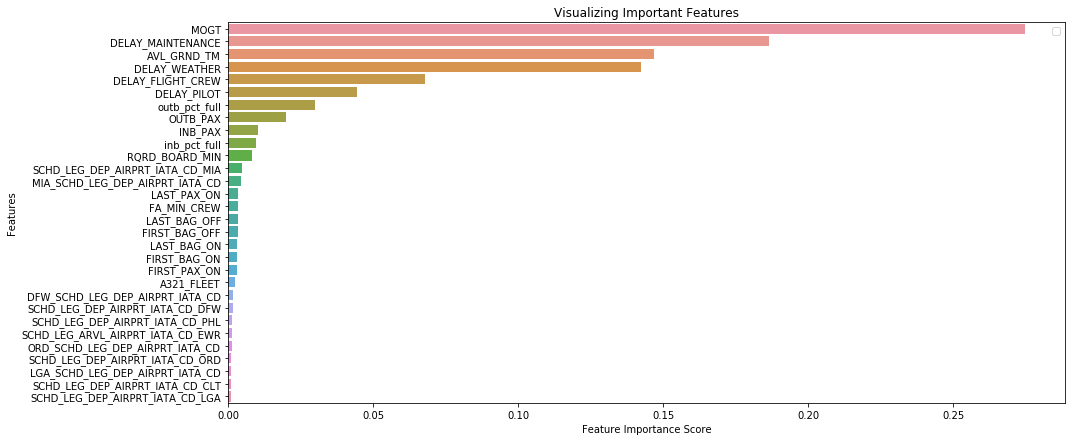

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a bar plot
plt.figure(figsize=(15,7))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Create Random Forest Model with Important Features

In [26]:
from pandasql import sqldf
features = sqldf('''SELECT TURN_TIME, MOGT, 
        DELAY_MAINTENANCE, DELAY_WEATHER, AVL_GRND_TM,
       DELAY_FLIGHT_CREW, DELAY_PILOT, outb_pct_full, OUTB_PAX,
       INB_PAX, inb_pct_full, RQRD_BOARD_MIN,
       MIA_SCHD_LEG_DEP_AIRPRT_IATA_CD, SCHD_LEG_DEP_AIRPRT_IATA_CD_MIA,
       LAST_PAX_ON, FIRST_BAG_OFF, LAST_BAG_ON, FIRST_BAG_ON,
       LAST_BAG_OFF, FIRST_PAX_ON, FA_MIN_CREW, 
       DFW_SCHD_LEG_DEP_AIRPRT_IATA_CD, SCHD_LEG_DEP_AIRPRT_IATA_CD_DFW,
       SCHD_LEG_ARVL_AIRPRT_IATA_CD_EWR, SCHD_LEG_DEP_AIRPRT_IATA_CD_PHL,
       SCHD_LEG_DEP_AIRPRT_IATA_CD_LGA, LGA_SCHD_LEG_DEP_AIRPRT_IATA_CD,
       ORD_SCHD_LEG_DEP_AIRPRT_IATA_CD, SCHD_LEG_DEP_AIRPRT_IATA_CD_ORD,
       SCHD_LEG_DEP_AIRPRT_IATA_CD_CLT
                   FROM imp_features''')
labels = np.array(features['TURN_TIME'])
features = features.drop(['TURN_TIME'], axis=1)
features_list=features.columns
features = np.array(features)

### K Fold Cross Validation 

This section randomly splits the dataset into K folds. For each K fold, the model is built around K-1 folds of the dataset. The model is tested for effectiveness on the Kth fold.

In [27]:
# K fold cross validation
from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=None) 

for train_index, test_index in kf.split(features):
      print("Train:", train_index, "Validation:",test_index)
      X_train, X_test = features[train_index], features[test_index] 
      y_train, y_test = labels[train_index], labels[test_index]

Train: [     0      1      2 ... 158057 158058 158059] Validation: [     8     14     16 ... 158040 158046 158053]
Train: [     0      3      4 ... 158056 158057 158058] Validation: [     1      2      7 ... 158010 158055 158059]
Train: [     0      1      2 ... 158057 158058 158059] Validation: [    42     54     58 ... 158047 158052 158056]
Train: [     1      2      3 ... 158057 158058 158059] Validation: [     0     28     45 ... 158037 158039 158054]
Train: [     0      1      2 ... 158057 158058 158059] Validation: [     6      9     12 ... 158029 158049 158050]
Train: [     0      1      2 ... 158056 158058 158059] Validation: [    11     34     38 ... 158045 158048 158057]
Train: [     0      1      2 ... 158057 158058 158059] Validation: [     5     19     22 ... 158014 158042 158043]
Train: [     0      1      2 ... 158057 158058 158059] Validation: [     4     10     27 ... 157996 158030 158051]
Train: [     0      1      2 ... 158057 158058 158059] Validation: [     3     1

Train: [     0      1      2 ... 158055 158058 158059] Validation: [     3     12     13 ... 158044 158056 158057]
Train: [     0      1      2 ... 158056 158057 158059] Validation: [     4      5     21 ... 158050 158054 158058]
Train: [     0      1      2 ... 158057 158058 158059] Validation: [    29     46     52 ... 158032 158042 158046]
Train: [     0      1      3 ... 158057 158058 158059] Validation: [     2     16     32 ... 158037 158045 158047]
Train: [     0      1      2 ... 158056 158057 158058] Validation: [     7      9     37 ... 158025 158031 158059]
Train: [     0      1      2 ... 158057 158058 158059] Validation: [    14     23     30 ... 158009 158040 158053]
Train: [     1      2      3 ... 158057 158058 158059] Validation: [     0     22     25 ... 158012 158017 158051]
Train: [     0      2      3 ... 158057 158058 158059] Validation: [     1      6     11 ... 158028 158036 158049]
Train: [     0      1      4 ... 158057 158058 158059] Validation: [     2      

### Train RF Model

Here we're using a scikit learn randomf forest regressor and tuning the hyperparameters. A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [28]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, 
                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                           bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                           verbose=0, warm_start=False)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### Make Prediction on Test Set

In [29]:
predictions = rf.predict(X_test)

# Calculate the Mean Absolute Error
mae = round(mean_absolute_error(y_test, predictions)/60,2)
print('Mean Absolute Error:', mae, 'minutes.')

# Calculate the Mean Absolute Percent Error
errors = abs(predictions - y_test)
mape = 100 * (errors / y_test)

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%')

Mean Absolute Error: 10.72 minutes.
Accuracy: 83.1 %


### Final Results

In [30]:
# Create a DataFrame using the testing set
imptestdf = pd.DataFrame(X_test, columns=features_list)

# Add the prediction and actual outcome columns
imptestdf['prediction'] = predictions
imptestdf['actual'] = y_test

# Add the prediction and actual under_MOGT columns
imptestdf['actual_under_MOGT'] = imptestdf['actual'] <= (imptestdf['MOGT'] * 60)
imptestdf['pred_under_MOGT'] = imptestdf['prediction'] <= (imptestdf['MOGT'] * 60)

# Add a column to show if our prediction was correct
imptestdf['correct'] = imptestdf['actual_under_MOGT'] == imptestdf['pred_under_MOGT']


imptestdf.head()

,MOGT,DELAY_MAINTENANCE,DELAY_WEATHER,AVL_GRND_TM,DELAY_FLIGHT_CREW,DELAY_PILOT,outb_pct_full,OUTB_PAX,INB_PAX,inb_pct_full,...,SCHD_LEG_DEP_AIRPRT_IATA_CD_LGA,LGA_SCHD_LEG_DEP_AIRPRT_IATA_CD,ORD_SCHD_LEG_DEP_AIRPRT_IATA_CD,SCHD_LEG_DEP_AIRPRT_IATA_CD_ORD,SCHD_LEG_DEP_AIRPRT_IATA_CD_CLT,prediction,actual,actual_under_MOGT,pred_under_MOGT,correct
0,50.0,0.0,0.0,48.0,0.0,0.0,0.859375,110.0,93.0,0.726562,...,0.0,0.0,0.0,0.0,0.0,2991.6,2580,True,True,True
1,60.0,0.0,0.0,-88.0,0.0,0.0,0.921875,118.0,112.0,0.875000,...,0.0,0.0,0.0,0.0,0.0,4062.6,4260,False,False,True
2,45.0,0.0,0.0,17.0,0.0,0.0,0.960938,123.0,128.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,2929.2,3840,False,False,True
3,40.0,0.0,0.0,33.0,0.0,1.0,1.000000,128.0,102.0,0.796875,...,0.0,0.0,0.0,0.0,0.0,3173.4,3540,False,False,True
4,55.0,0.0,0.0,9.0,0.0,0.0,1.000000,128.0,126.0,0.984375,...,0.0,0.0,0.0,0.0,0.0,4355.4,3720,False,False,True


### Accuracy 

In [31]:
print('Accuracy Score: {:.2%}'.format(imptestdf.correct.sum() / len(imptestdf.correct)))

Accuracy Score: 63.60%


#### Prediction 
The following cell is interactive. Please add your prediction

In [32]:
# Predict the outcome of turn time by setting the values of the features below: 
##################################################################################################################
# This is a work in progress and may not be needed if we're not having a demo of the model
##################################################################################################################

def flight_predictor():
    INB_PAX = float(input("Inbound Passengers:  "))
    inb_pct_full = INB_PAX/SEATS
    OUTB_PAX = float(input("Outbound Passengers:  "))
    outb_pct_full = OUTB_PAX/SEATS
    AVL_GRND_TM = float(input("Available Ground Time:  "))
    RQRD_BOARD_MIN = float(input("Required Boarding Minutes:  "))
    MOGT = float(input("MOGT: "))
    FIRST_BAG_OFF = float(input("First Bag Off:  "))
    MEDIAN_BAG_OFF = float(input("Median Bag On:  "))
    LAST_BAG_OFF = float(input("Last Bag Off: "))
    FA_MIN_CREW = float(input("Minimum Crew:  "))
    arrival_hour = float(input("Arrival Hour:  "))
    sched_month = float(input("Scheduled Month:  "))
    sched_day_of_week = float(input("Scheduled Day of Week:  "))
    sched_hour = float(input("Scheduled Hour: "))

    STATION_TYPE = input("Station Type - HUB, SPOKE, INTL")
    DELAY = input("Delay Reason - FC, MNTC, PILOT, WEATHER, NO")

#     if STATION_TYPE = 'HUB':
#         HUB_STATION_TYPE = 1
#     elif STATION_TYPE = 'SPOKE':
#         SPOKE_STATION_TYPE = 1
#     else: 
#         INTL_STATION_TYPE = 1
        
#     AIRLINE_AA=1
    
    rf.predict([[INB_PAX, MOGT, OUTB_PAX, AVL_GRND_TM, RQRD_BOARD_MIN, SCHD_LEG_DEP_AIRPRT_IATA_CD, 
                SCHD_LEG_ARVL_AIRPRT_IATA_CD, FIRST_BAG_OFF, LAST_BAG_OFF, FIRST_BAG_ON, LAST_BAG_ON, 
                FA_MIN_CREW, FIRST_PAX_ON, LAST_PAX_ON, inb_pct_full, outb_pct_full, 
                sched_month, sched_day_of_week, sched_hour, arrival_hour, AIRLINE_AA, A319_FLEET, 
                A320_FLEET, A321_FLEET, A737_FLEET, A757_FLEET, E90_FLEET, MIA_INB_FLIGHT, DFW_INB_FLIGHT, 
                DCA_INB_FLIGHT, LAX_INB_FLIGHT, ORD_INB_FLIGHT, LGA_INB_FLIGHT, BOS_INB_FLIGHT, 
                SFO_INB_FLIGHT, MIA_INB_ACT_ORIG, DFW_INB_ACT_ORIG, DCA_INB_ACT_ORIG, LAX_INB_ACT_ORIG, 
                ORD_INB_ACT_ORIG, LGA_INB_ACT_ORIG, BOS_INB_ACT_ORIG, SFO_INB_ACT_ORIG, 
                MIA_SCHD_LEG_DEP_AIRPRT_IATA_CD, DFW_SCHD_LEG_DEP_AIRPRT_IATA_CD, DCA_SCHD_LEG_DEP_AIRPRT_IATA_CD, 
                LAX_SCHD_LEG_DEP_AIRPRT_IATA_CD, ORD_SCHD_LEG_DEP_AIRPRT_IATA_CD, LGA_SCHD_LEG_DEP_AIRPRT_IATA_CD, 
                BOS_SCHD_LEG_DEP_AIRPRT_IATA_CD, SFO_SCHD_LEG_DEP_AIRPRT_IATA_CD, MIA_SCHD_LEG_ARVL_AIRPRT_IATA_CD, 
                DFW_SCHD_LEG_ARVL_AIRPRT_IATA_CD, DCA_SCHD_LEG_ARVL_AIRPRT_IATA_CD, LAX_SCHD_LEG_ARVL_AIRPRT_IATA_CD, 
                ORD_SCHD_LEG_ARVL_AIRPRT_IATA_CD, LGA_SCHD_LEG_ARVL_AIRPRT_IATA_CD, BOS_SCHD_LEG_ARVL_AIRPRT_IATA_CD, 
                SFO_SCHD_LEG_ARVL_AIRPRT_IATA_CD, DELAY_FLIGHT_CREW, DELAY_MAINTENANCE, DELAY_WEATHER, DELAY_PILOT]])

flight_predictor()

Inbound Passengers:  k


ValueError: could not convert string to float: 'k'